### checklist
clean myfunctions file
try removing outliers by hand ( min and max values)  
data pre processing ( remove none, nan...)  
find the oulier discovered with standardisation  
check if possible to add feature  
compute number of final data fitted in model  

small final report on model  
name, score, graphs, metrics  


try a prediction  

import scrapping folder  
restructure folder , one by step  
requirement update  


pandas basic exploration  

In [126]:
import pandas as pd
import numpy as np
from numpy import ravel
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import d2_absolute_error_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from scripts.functions import get_dataset
from scripts.functions import add_zipcode
from scripts.functions import add_province
from scripts.functions import add_region
from scripts.functions import set_type
from scripts.functions import set_feat_target
from scripts.functions import regline

import sys
# Ensure that import from parent directory is correctly implemented
sys.path.append('..')
from scripts.colors import bcolors as bc

<H1 style= "color:white; background-color:grey; text-align:center; border-radius: 10px; padding-bottom: 0.2em">Modeling</H1>


- Load datas
- Add zipcode from csv, based on locality column
- Add Provinces based on zipcode

In [127]:
# Load the datas 
file = '../datas/Immoweb_data_ok_maite.csv'
data = get_dataset(file)
data.head()
# data.dtypes

,Id,Locality,House or appartment?,Subtype,Price,Type of sale,Number of rooms,Living area,Fully equipped kitchen,Furnished,Open fire,Terrace,Area of terrace,Garden,Area of garden,Land surface,Number of facades,Swimming pool,State of building
0,10233388,Uccle,HOUSE,HOUSE,1295000.0,BUY_REGULAR,4.0,290.0,1,None,0,1,15,None,None,230,2,0,GOOD
2,10310451,Anderlecht,APARTMENT,APARTMENT,357500.0,BUY_REGULAR,3.0,119.0,0,None,0,1,16,None,None,None,4,None,NaN
3,10309870,Uccle,APARTMENT,APARTMENT,295000.0,BUY_REGULAR,2.0,140.0,0,None,0,None,None,None,None,None,2,None,TO_BE_DONE_UP
4,10309546,Uccle,APARTMENT,APARTMENT,199000.0,BUY_REGULAR,1.0,61.0,0,None,0,1,2,None,None,None,2,None,NaN
5,10308639,Berchem-Sainte-Agathe,HOUSE,HOUSE,485000.0,BUY_REGULAR,3.0,235.0,0,None,0,None,None,1,100,200,2,0,TO_BE_DONE_UP


### Explore dataset

In [128]:
# data[data['Number of rooms'] >7]
# data.isnull().sum()
# data['Subtype'].unique()
# data.dtypes
# data.describe()

### Adding columns in the dataframe

In [129]:

# Add zipcode column
zip_path = "../datas/Postal_codes.csv"
data = add_zipcode(zip_path, data)
# Add Province column
data = add_province(data)
# Add Region column
data = add_region(data)
# Clean and set column type 
data = set_type(data)
# Explore data
data.head()
# data.dtypes
# data.isnull().sum()
# data['Subtype'].unique()
# data.dtypes



,Id,Locality,House or appartment?,Subtype,Price,Type of sale,Number of rooms,Living area,Fully equipped kitchen,Furnished,...,Area of terrace,Garden,Area of garden,Land surface,Number of facades,Swimming pool,State of building,zip_code,Province,Region
0,10233388,uccle,HOUSE,HOUSE,1295000.0,BUY_REGULAR,4,290.0,1,None,...,15,None,0,230.0,2.0,0,GOOD,1180.0,Bruxelles,Brux
2,10310451,anderlecht,APARTMENT,APARTMENT,357500.0,BUY_REGULAR,3,119.0,0,None,...,16,None,0,0.0,4.0,None,NaN,1070.0,Bruxelles,Brux
3,10309870,uccle,APARTMENT,APARTMENT,295000.0,BUY_REGULAR,2,140.0,0,None,...,None,None,0,0.0,2.0,None,TO_BE_DONE_UP,1180.0,Bruxelles,Brux
4,10309546,uccle,APARTMENT,APARTMENT,199000.0,BUY_REGULAR,1,61.0,0,None,...,2,None,0,0.0,2.0,None,NaN,1180.0,Bruxelles,Brux
5,10308639,berchem-sainte-agathe,HOUSE,HOUSE,485000.0,BUY_REGULAR,3,235.0,0,None,...,None,1,100,200.0,2.0,0,TO_BE_DONE_UP,1082.0,Bruxelles,Brux


In [130]:
# print(data.info())
# print(data.describe())
# print(data['Region'].value_counts())
# print(data['Number of rooms'].value_counts())
# data['Number of facades'].unique()

<p style="color:white; background-color:grey; text-align:center; border-radius: 10px; padding-bottom: 0.5em">Correlation</p>

C:\Users\test\AppData\Local\Temp\ipykernel_9424\540660637.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


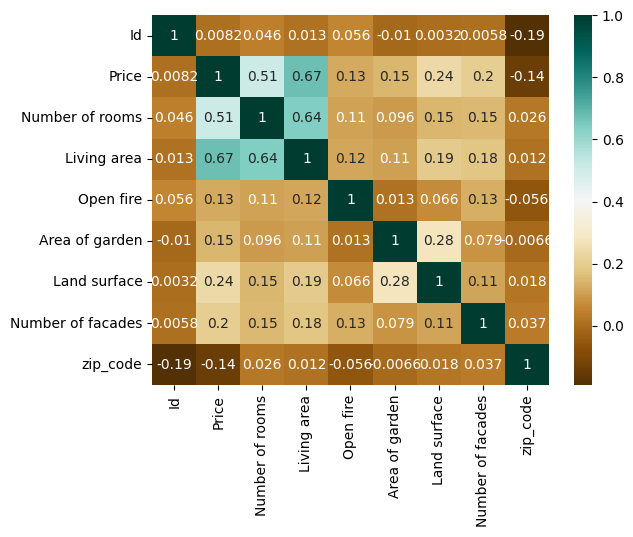

In [131]:
correlation = data.corr()
dataplot = sns.heatmap(correlation, cmap="BrBG", annot=True)

### Sort correlation to Price

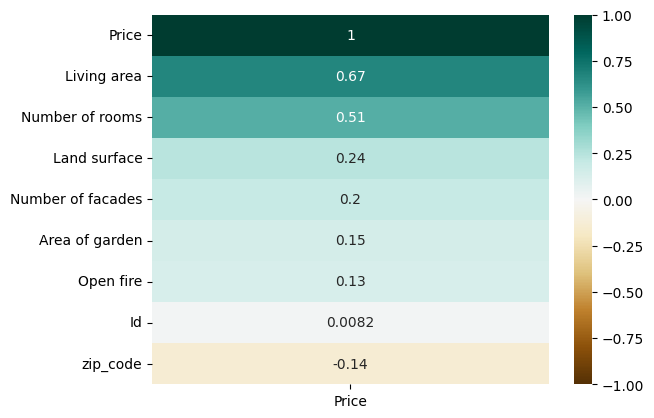

In [132]:
heatmap = sns.heatmap(correlation[['Price']].sort_values(by='Price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

### Explore data outliers

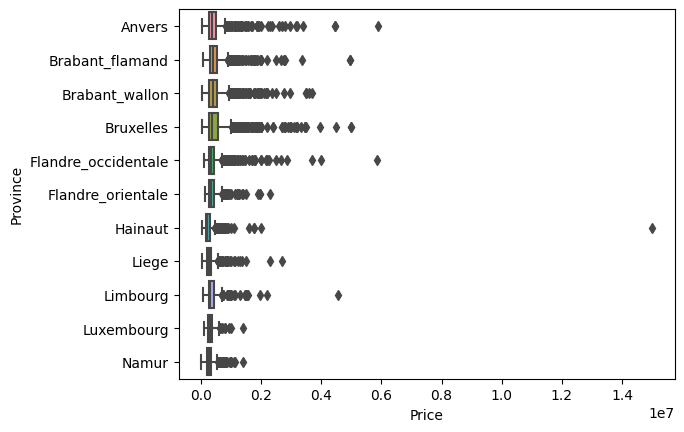

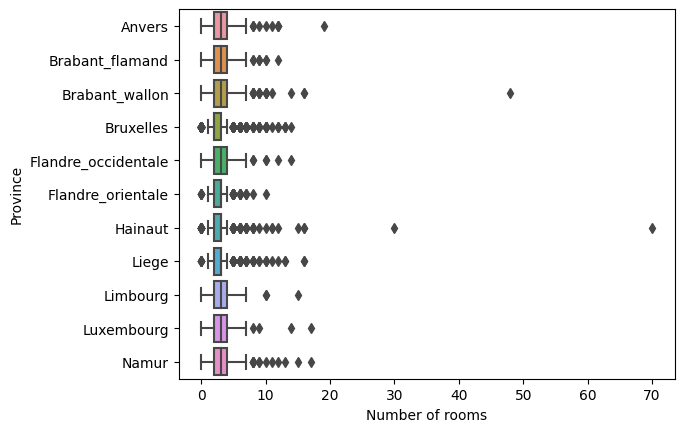

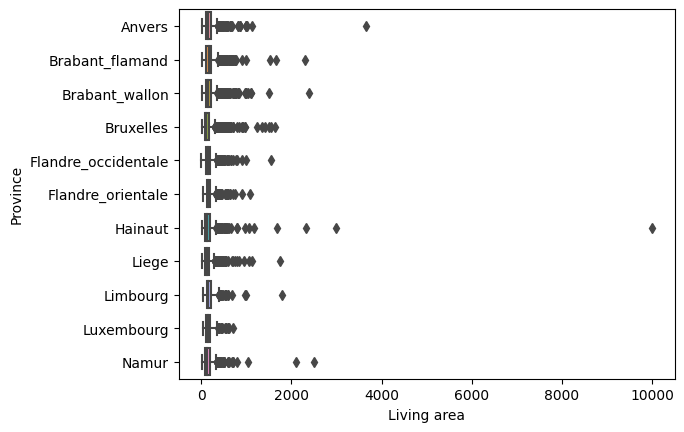

In [133]:
plt.figure()
outliers_Price = sns.boxplot(data=data, x="Price", y='Province')
plt.figure()
outliers_Number_of_rooms = sns.boxplot(data=data, x="Number of rooms", y='Province')
plt.figure()
outliers_Living_area = sns.boxplot(data=data, x="Living area", y='Province')
# sns.close()


### Remove outliers

In [148]:
# print(data['Price'].describe())

# Remove outliers from Price column
q1_price , q3_price = data['Price'].quantile([0.25,0.75])
iqr_price = q3_price - q1_price
print(q1_price, q3_price, iqr_price)
iqr_coef = 1.5
data = data[(data['Price'] > (q1_price - (iqr_coef*iqr_price))) & (data['Price'] < (q3_price + (iqr_coef*iqr_price)))]
# print(data['Price'].describe())

# Remove outliers from Living area column
print(data['Living area'].describe())
q1_la , q3_la = data['Living area'].quantile([0.25,0.75])
iqr_price = q3_la - q1_la
print(q1_la, q3_la, iqr_price)
iqr_coef = 1.5
data = data[(data['Living area'] > (q1_la - (iqr_coef*iqr_price))) & (data['Living area'] < (q3_la + (iqr_coef*iqr_price)))]
# print(data['Living area'].describe())

# Remove outliers from Number of rooms column
# print(data['Number of rooms'].describe())
# q1_nr , q3_nr = data['Number of rooms'].quantile([0.25,0.75])
# iqr_price = q3_nr - q1_nr
# print(q1_nr, q3_nr, iqr_price)
# iqr_coef = 5
# data = data[(data['Number of rooms'] > (q1_nr - (iqr_coef*iqr_price))) & (data['Number of rooms'] < (q3_nr + (iqr_coef*iqr_price)))]
data = data[(data['Number of rooms'] > 0) & (data['Number of rooms'] < 20)]
# print(data['Number of rooms'].describe())

plt.show()

240000.0 417387.5 177387.5
count    8392.000000
mean      139.244399
std        57.434746
min         1.000000
25%        95.000000
50%       130.000000
75%       175.000000
max       318.000000
Name: Living area, dtype: float64
95.0 175.0 80.0


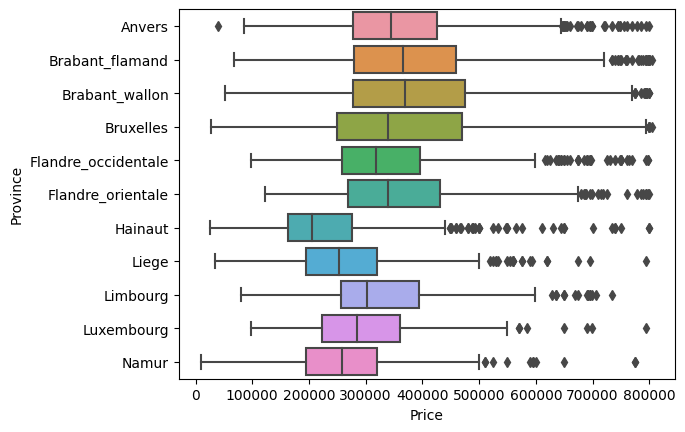

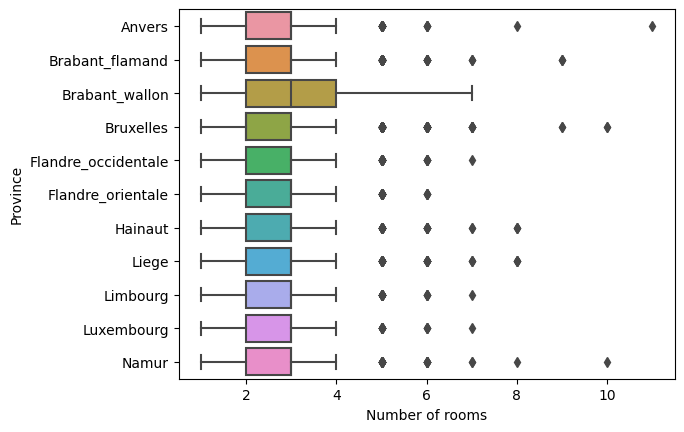

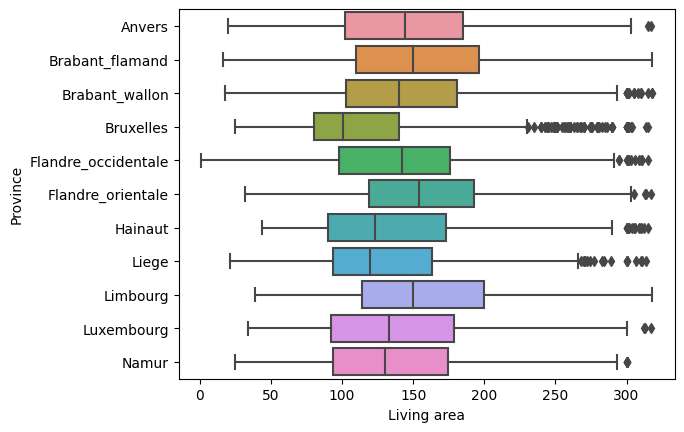

In [135]:
plt.figure()
outliers_removed_Price = sns.boxplot(data=data, x="Price", y='Province')
plt.figure()
outliers_removed_Number_of_rooms = sns.boxplot(data=data, x="Number of rooms", y='Province')
plt.figure()
outliers_removed_Living_area = sns.boxplot(data=data, x="Living area", y='Province')
# sns.close()

### Select target (HOUSES prices) and features from the dataframe

- Slice df for modeling
- Categorical to numerical
- Split feature, target
- Split train, test
- Normalize or standardise

In [147]:
# Select columns for modeling
# print(data.columns)
data_model_house = data[data['House or appartment?'] == 'HOUSE'][['Price', 'Province', 'Living area','Number of rooms', 'Number of facades', 'Subtype', 'State of building', 'Land surface', 'Area of garden']]
# print(data_model_house.head())
# print(data_model_house.shape[0])

# Get dummies for Categorical columns
data_model_house = pd.get_dummies(data_model_house, columns =['Province'],drop_first=False )
data_model_house = pd.get_dummies(data_model_house, columns =['Subtype'],drop_first=False )
data_model_house = pd.get_dummies(data_model_house, columns =['State of building'],drop_first=False )
# print(data_model_house.columns)
print(f'Number of rows fitted in the model : {data_model_house.shape[0]}')

# Split features, target
X, y = set_feat_target(data_model_house)

# Split into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 67)

# Standardisation
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# print(f"y head : {y[:1,:]},\nX head : {X[:1,:]}")
# print(f"y_test first : {y_test[:1,:]},\nX_test first : {X_test[:1,:]}")

Number of rows fitted in the model : 5013


<H2 style= "color:orange; background-color:grey; text-align:center; border-radius: 10px; padding-bottom: 0.5em">Linear Regression</H2>
- Instanciate linear regression  
- Fit the model and get score  
- Test the model and get score  


In [142]:
# Model instanciation
regressor = linear_model.LinearRegression()
# regressor = GradientBoostingRegressor()

# Train the model
if type(regressor) == sklearn.ensemble._gb.GradientBoostingRegressor:
    regressor.fit(X_train, ravel(y_train))
    reg_params = regressor.get_params()
else:
    regressor.fit(X_train, (y_train))
    print(f"REGRESSOR\n {bc.OKBLUE}Intercept{bc.ENDC}: {regressor.intercept_[0]},\n {bc.OKBLUE}Coef{bc.ENDC}:{regressor.coef_[0]}")

# Model accuracy (train set)
accuracy_train = round(regressor.score(X_train, y_train)*100,2)
print(f"Regressor {bc.OKBLUE}train{bc.ENDC} score R²: {bc.OKGREEN if accuracy_train > 60 else bc.WARNING if accuracy_train > 50 else bc.FAIL}{accuracy_train}{bc.ENDC} %")

# Test model accuracy (test set)
accuracy_test = round(regressor.score(X_test, y_test)*100, 2)
print(f"Regressor {bc.OKBLUE}test{bc.ENDC} score R²: {bc.OKGREEN if accuracy_test > 60 else bc.WARNING if accuracy_test > 50 else bc.FAIL}{accuracy_test}{bc.ENDC} %")

# Prediction
pred_test = regressor.predict(X_test)
pred_train = regressor.predict(X_train)



REGRESSOR
 Intercept: 364416.96501219517,
 Coef:[ 5.66811444e+04  1.16790024e+04  2.51354057e+04  3.87796246e+03
  3.98429900e+03  1.80722918e+17  2.38728477e+17  2.11227843e+17
  1.51544981e+17  1.73601416e+17  1.85109142e+17  1.70537682e+17
  1.57652788e+17  1.31558095e+17  9.21296136e+16  1.57156065e+17
 -7.59968047e+16 -1.15021237e+17 -6.83990472e+16  6.91628262e+16
 -3.20357067e+16 -5.34852410e+16 -5.98725172e+16 -5.05578364e+16
 -3.20357067e+16 -3.52914458e+16 -2.51403640e+16 -2.54984102e+17
 -4.96389517e+15  3.57640832e+16 -2.26668189e+16 -5.62564250e+16
 -1.00646305e+17 -2.26668189e+16 -1.01419705e+16 -2.86851903e+16
  6.40000000e+01 -8.29310339e+16  0.00000000e+00 -1.74800288e+17
  4.97410114e+03 -8.97882322e+03  1.44100220e+03 -9.18376635e+02
 -1.98412363e+04 -3.20033600e+04 -1.04555673e+04]
Regressor train score R²: 59.95 %
Regressor test score R²: 55.68 %


<p style="color:white; background-color:grey; text-align:center; border-radius: 10px; padding-bottom: 0.5em">Metrics</p>

In [143]:
print('Train set')
print(f"MAE: {round(mean_absolute_error(y_train, pred_train),2)} €")
print(f"MAPE : {round(mean_absolute_percentage_error(y_train, pred_train)*100,2)} %")
print(f"Median Absolute Error : {round(median_absolute_error(y_train, pred_train),2)} €")
print(f"D2 :{round(d2_absolute_error_score(y_train, pred_train),4)}")

Train set
MAE: 71955.88 €
MAPE : 23.21 %
Median Absolute Error : 53853.39 €
D2 :0.3921


In [144]:
print('Test set')
print(f"MAE: {round(mean_absolute_error(y_test, pred_test),2)} €")
print(f"MAPE : {round(mean_absolute_percentage_error(y_test, pred_test)*100,2)} %")
print(f"Median Absolute Error : {round(median_absolute_error(y_test, pred_test),2)} €")
print(f"D2 :{round(d2_absolute_error_score(y_test, pred_test),4)}")

Test set
MAE: 75390.23 €
MAPE : 27.88 %
Median Absolute Error : 60102.29 €
D2 :0.367


<p style="color:white; background-color:grey; text-align:center; border-radius: 10px; padding-bottom: 0.5em">Cross Validation</p>

In [145]:
cv_score = cross_val_score(regressor, X, ravel(y), cv=5)
print(f"Cross validation score {cv_score}")
print(f"Mean Cross Validation Score :{np.mean(cv_score)}.")

Cross validation score [ 0.49601548 -0.79205206  0.57211949  0.53791076  0.57880378]
Mean Cross Validation Score :0.27855949136617186.


<p style="color:white; background-color:grey; text-align:center; border-radius: 10px; padding-bottom: 0.5em">Plot results</p>

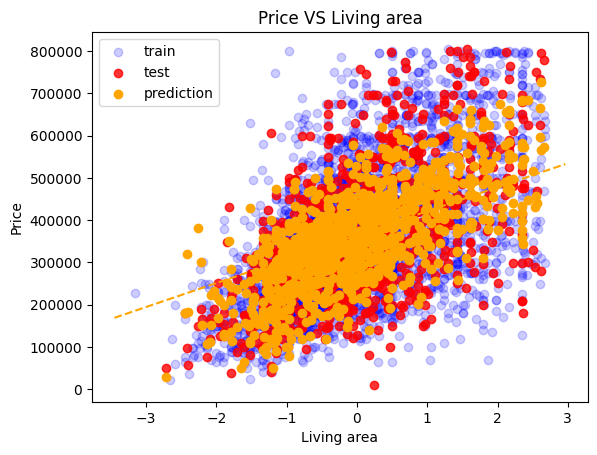

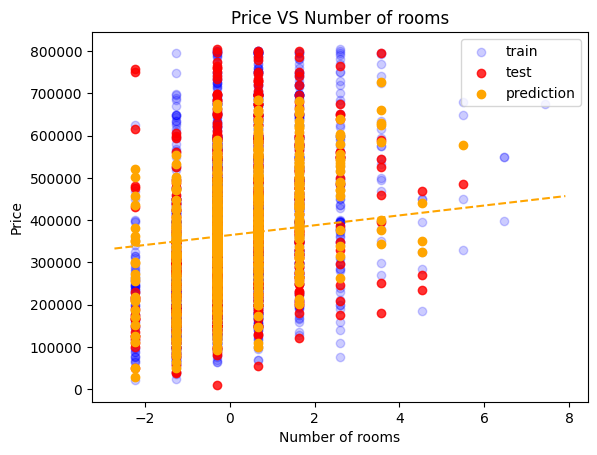

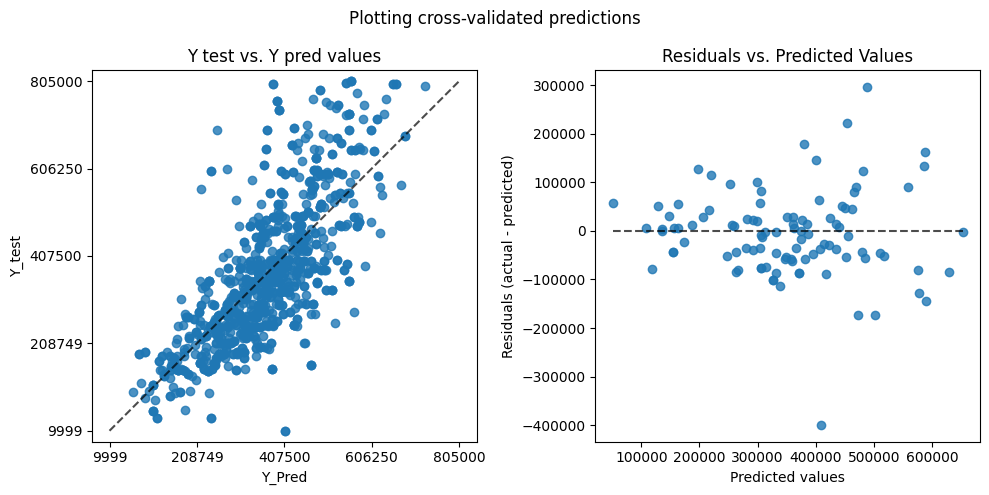

In [146]:
# X[0] = "Living Area"
# X[1] = "Number of rooms"
# X[2:] = "Province"

# Price vs Living area
# Plot the predicted values against the input values
plt.scatter(X_train[:,0], y_train, color='blue',alpha=0.2, label='train')
# plt.scatter(X_train[:,0], pred_train, color='red')
plt.scatter(X_test[:,0], y_test, color='red', alpha=0.8, label='test')
plt.scatter(X_test[:,0], pred_test, color='orange', label='prediction')
if type(regressor) == sklearn.ensemble._gb.GradientBoostingRegressor:
    # plt.plot([X_test[0].min(), pred_test.min()], [X_test[0].max(), pred_test.max()], 'r', lw=2)
    pass
else:
    line_Living_area = regline(regressor.coef_[0][0],regressor.intercept_[0],'orange')

# Label the plot
plt.title("Price VS Living area")
plt.xlabel('Living area')
plt.ylabel('Price')
plt.legend(loc='upper left')

# Show the plot
plt.show()
plt.close()

# Price vs Number of rooms
# Plot the predicted values against the input values
plt.scatter(X_train[:,1], y_train, color='blue', alpha=0.2, label='train')
# plt.scatter(X_train[:,1], pred_train, color='red')
plt.scatter(X_test[:,1], y_test, color='red', alpha=0.8, label='test')
plt.scatter(X_test[:,1], pred_test, color='orange', label='prediction')
# print(regressor.intercept_[0],regressor.coef_[0][1])
if type(regressor) == sklearn.ensemble._gb.GradientBoostingRegressor:
    # plt.plot([X_test[1].min(), pred_test.min()], [X_test[1].max(), pred_test.max()], 'r', lw=2)
    pass
else:
    line_Number_rooms = regline(regressor.coef_[0][1],regressor.intercept_[0],'orange')

# Label the plot
plt.title("Price VS Number of rooms")
plt.xlabel('Number of rooms')
plt.ylabel('Price')
plt.legend(loc='upper right')

# Show the plot
plt.show()
plt.close()

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=pred_test,
    kind="actual_vs_predicted",
    # subsample=100,
    ax=axs[0],
    # random_state=0,
)
axs[0].set_title("Y test vs. Y pred values")
axs[0].set_xlabel("Y_Pred")
axs[0].set_ylabel("Y_test")

if type(regressor) == sklearn.ensemble._gb.GradientBoostingRegressor:
    PredictionErrorDisplay.from_predictions(
        ravel(y_test),
        y_pred=pred_test,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
else:
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=pred_test,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()
plt.close()
